<a href="https://colab.research.google.com/github/jinglescode/time-series-forecasting-pytorch/blob/main/demo-predicting-stock-prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Stock Prices with Deep Neural Networks

This project walks you through the end-to-end data science lifecycle of developing a predictive model for stock price movements with YFinance APIs and a powerful machine learning algorithm called Long Short-Term Memory (LSTM). By completing this project, you will learn the key concepts of machine learning / deep learning and build a fully functional predictive model for the stock market, all in a single Python file.

In [46]:
#@title Load Python libraries
import numpy as np
import yfinance as yf

# pip install torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

print("All libraries loaded")

All libraries loaded


In [47]:
config = {
    "yfinance": {
        "symbol": "MSFT",
        "start_date": "2019-01-01",
        "end_date": "2023-07-31",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "show_plots": True,
        "xticks_interval": 30,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        # "device": "cpu", # "cuda" or "cpu"
        "device": "cuda",
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

In [48]:
df = yf.download(config["yfinance"]["symbol"], start=config["yfinance"]["start_date"], end=config["yfinance"]["end_date"])


[*********************100%***********************]  1 of 1 completed


In [49]:
df["Adj Close"].index

DatetimeIndex(['2019-01-02 00:00:00+00:00', '2019-01-03 00:00:00+00:00',
               '2019-01-04 00:00:00+00:00', '2019-01-07 00:00:00+00:00',
               '2019-01-08 00:00:00+00:00', '2019-01-09 00:00:00+00:00',
               '2019-01-10 00:00:00+00:00', '2019-01-11 00:00:00+00:00',
               '2019-01-14 00:00:00+00:00', '2019-01-15 00:00:00+00:00',
               ...
               '2023-07-17 00:00:00+00:00', '2023-07-18 00:00:00+00:00',
               '2023-07-19 00:00:00+00:00', '2023-07-20 00:00:00+00:00',
               '2023-07-21 00:00:00+00:00', '2023-07-24 00:00:00+00:00',
               '2023-07-25 00:00:00+00:00', '2023-07-26 00:00:00+00:00',
               '2023-07-27 00:00:00+00:00', '2023-07-28 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=1151, freq=None)

## Data preparation: acquiring financial market data from YFinance

[*********************100%***********************]  1 of 1 completed

Number data points: 1151 from 2019-01-02 to 2023-07-28


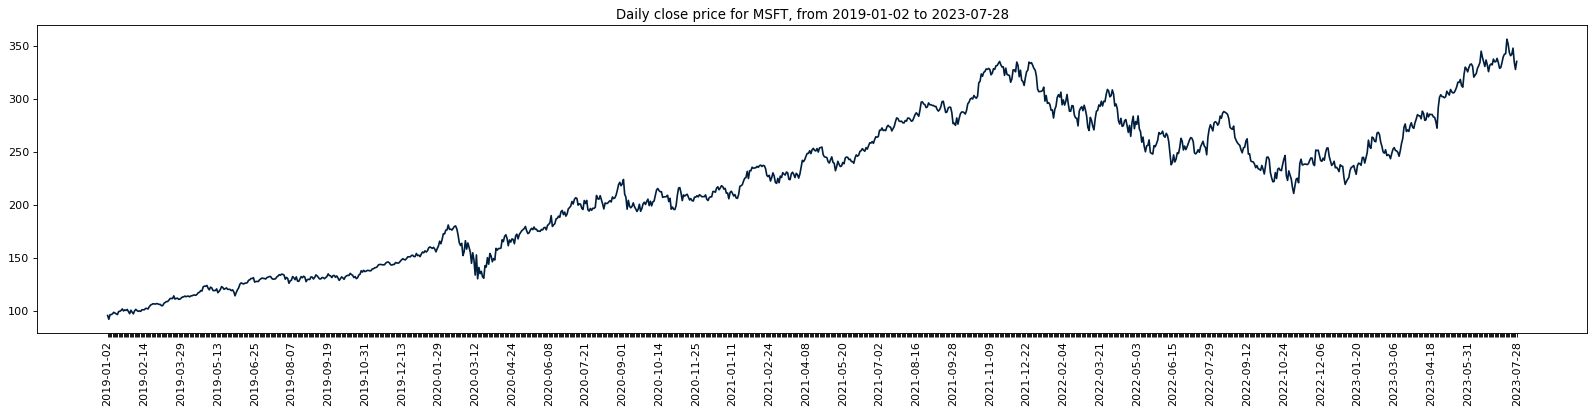

In [50]:
def download_data(config, plot=False):
    # get the data from yfinance

    df = yf.download(config["yfinance"]["symbol"], start=config["yfinance"]["start_date"], end=config["yfinance"]["end_date"])


    data_date = df.index.strftime("%Y-%m-%d").to_numpy()

    data_close_price = df["Adj Close"].to_numpy()
    # data_close_price = df["Adj Close"].pct_change().iloc[1:].to_numpy()

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points:", num_data_points, display_date_range)

    if plot:
        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
        xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
        x = np.arange(0,len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title("Daily close price for " + config["yfinance"]["symbol"] + ", " + display_date_range)
        # plt.grid(which='major', axis='y', linestyle='--')
        plt.show()

    return data_date, data_close_price, num_data_points, display_date_range

data_date, data_close_price, num_data_points, display_date_range = download_data(config, plot=config["plots"]["show_plots"])

## Data preparation: normalizing raw financial data

In [51]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def transform(self, x):
        if not self.mu:
            raise NotImplementedError
        return (x - self.mu)/self.sd
    
    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        return self.transform(x)
    
    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

# normalize
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)

In [52]:
x = normalized_data_close_price
window_size = 20
n_row = x.shape[0] - window_size + 1
output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size), strides=(x.strides[0],x.strides[0]))
output[:-1].shape, output[-1].shape

((1131, 20), (20,))

## Data preparation: generating training and validation datasets

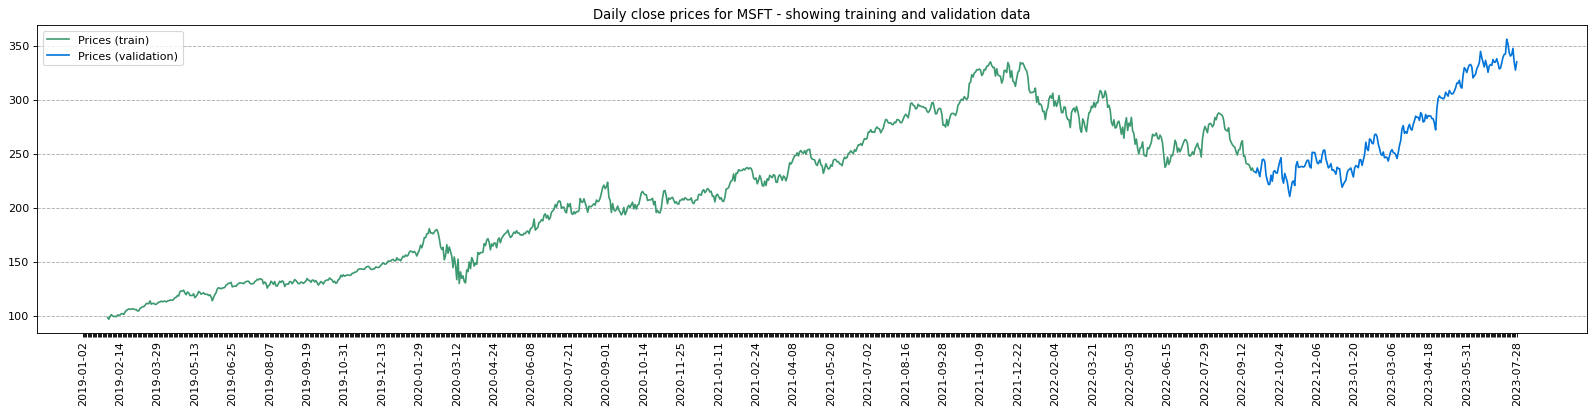

In [62]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size), strides=(x.strides[0],x.strides[0]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = x[window_size:]
    return output

# def prepare_data(normalized_data_close_price, config, plot=False):
def prepare_data(data_close_price, config, plot=False):
    scaler = Normalizer()
    split_index = int(data_close_price.shape[0]*config["data"]["train_split_size"])
    data_train = scaler.fit_transform(data_close_price[:split_index])
    data_test = scaler.transform(data_close_price[split_index:])
    normalized_data_close_price = np.vstack([data_train, data_test]).flatten()
    
    data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
    data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

    # split dataset

    # split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]
    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]

    if plot:
        # prepare data for plotting

        to_plot_data_y_train = np.zeros(num_data_points)
        to_plot_data_y_val = np.zeros(num_data_points)

        to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(data_y_train)
        to_plot_data_y_val[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(data_y_val)

        to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
        to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

        ## plots

        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
        plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
        xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
        x = np.arange(0,len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title("Daily close prices for " + config["yfinance"]["symbol"] + " - showing training and validation data")
        plt.grid(which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen

split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen = prepare_data(data_close_price, config, plot=config["plots"]["show_plots"])

In [54]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

Train data shape (920, 20, 1) (920, 1)
Validation data shape (211, 20, 1) (211, 1)


## Defining the LSTM model

In [55]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

## Model training

In [56]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

# create `DataLoader`
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

# define optimizer, scheduler and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

# begin training
for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    if not((epoch+1) % 10):
        print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))


/home/paulzhang/miniconda3/envs/ml_finance/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/paulzhang/miniconda3/envs/ml_finance/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24, 1])) that is different to the input size (torch.Size([24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/paulzhang/miniconda3/envs/ml_finance/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([19, 1])) that is different to the input size (torch.Size([19])). This will likely lead to incorrec

Epoch[10/100] | loss train:0.248318, test:0.118513 | lr:0.010000
Epoch[20/100] | loss train:0.249652, test:0.113961 | lr:0.010000
Epoch[30/100] | loss train:0.236077, test:0.110317 | lr:0.010000
Epoch[40/100] | loss train:0.235926, test:0.121671 | lr:0.010000
Epoch[50/100] | loss train:0.245157, test:0.090439 | lr:0.001000
Epoch[60/100] | loss train:0.242696, test:0.108324 | lr:0.001000
Epoch[70/100] | loss train:0.239662, test:0.099143 | lr:0.001000
Epoch[80/100] | loss train:0.246655, test:0.108010 | lr:0.001000
Epoch[90/100] | loss train:0.240694, test:0.104163 | lr:0.000100
Epoch[100/100] | loss train:0.256844, test:0.114787 | lr:0.000100


## Model evaluation

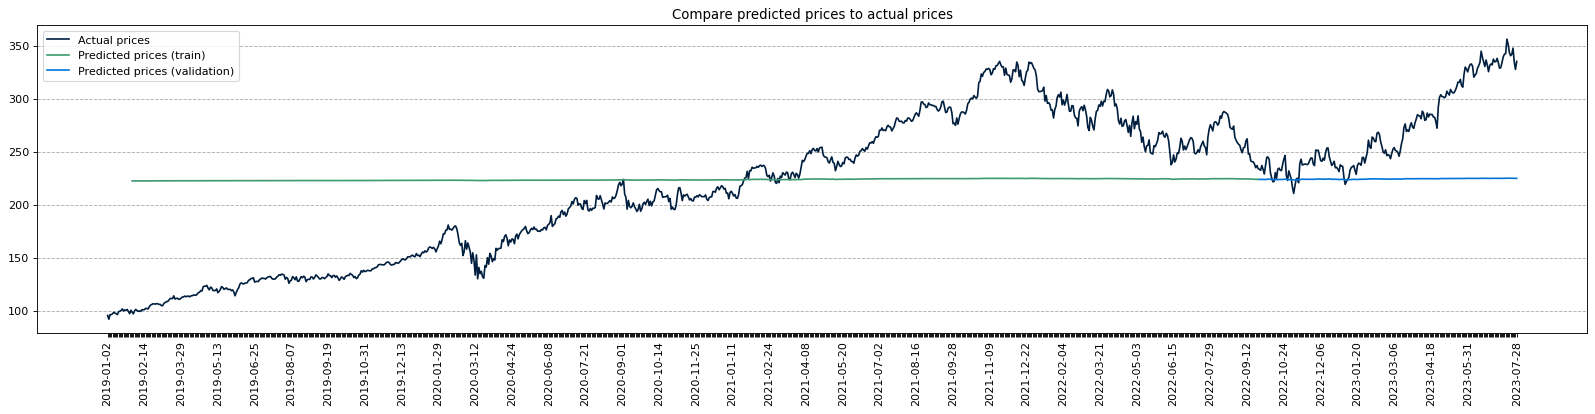

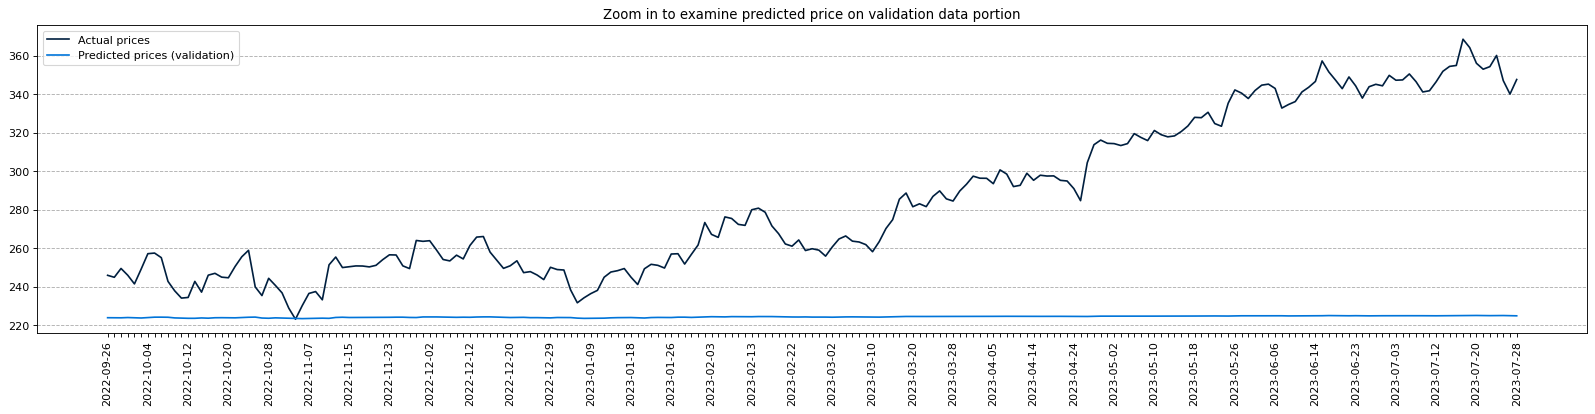

In [57]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

if config["plots"]["show_plots"]:

    # prepare data for plotting, show predicted prices

    to_plot_data_y_train_pred = np.zeros(num_data_points)
    to_plot_data_y_val_pred = np.zeros(num_data_points)

    to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
    to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

    to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(data_date, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
    plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Compare predicted prices to actual prices")
    xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
    x = np.arange(0,len(xticks))
    plt.xticks(x, xticks, rotation='vertical')
    plt.grid(which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

    # prepare data for plotting, zoom in validation

    to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)
    to_plot_predicted_val = scaler.inverse_transform(predicted_val)
    to_plot_data_date = data_date[split_index+config["data"]["window_size"]:]

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(to_plot_data_date, np.squeeze(to_plot_predicted_val), label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Zoom in to examine predicted price on validation data portion")
    xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
    xs = np.arange(0,len(xticks))
    plt.xticks(xs, xticks, rotation='vertical')
    plt.grid(which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

## Predicting future stock prices

In [58]:
# predict on the unseen data, tomorrow's price 

model.eval()

x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
prediction = model(x)
prediction = prediction.cpu().detach().numpy()
prediction = scaler.inverse_transform(prediction)[0]

if config["plots"]["show_plots"]:
        
    # prepare plots

    plot_range = 10
    to_plot_data_y_val = np.zeros(plot_range)
    to_plot_data_y_val_pred = np.zeros(plot_range)
    to_plot_data_y_test_pred = np.zeros(plot_range)

    to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(data_y_val)[-plot_range+1:]
    to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val)[-plot_range+1:]

    to_plot_data_y_test_pred[plot_range-1] = prediction

    to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
    to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

    # plot

    plot_date_test = list(data_date[-plot_range+1:])
    plot_date_test.append("next trading day")

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
    plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
    plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
    plt.title("Predicted close price of the next trading day")
    plt.grid(which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

print("Predicted close price of the next trading day:", round(prediction, 2))

ValueError: could not broadcast input array from shape (9,1) into shape (9,)